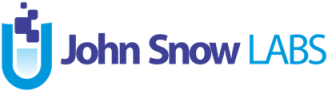

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/tutorials/llm_notebooks/Generic_API-Based_Model_Testing_Demo.ipynb)

**LangTest** is an open-source python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, Spacy** models or **OpenAI, Cohere, AI21, Hugging Face Inference API and Azure-OpenAI** based LLMs, it has got you covered. You can test any Named Entity Recognition (NER), Text Classification, fill-mask, Translation model using the library. We also support testing LLMS for Question-Answering, Summarization and text-generation tasks on benchmark datasets. The library supports 60+ out of the box tests. For a complete list of supported test categories, please refer to the [documentation](http://langtest.org/docs/pages/docs/test_categories).

# Getting started with LangTest

In [ ]:
!pip install "langtest[evaluate,openai]" requests

# Harness and Its Parameters

The Harness class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a NLP model on a given task using test data and generates a report with test results.Harness can be imported from the LangTest library in the following way.

In [2]:
import os

os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"

In [3]:
# Import Harness from the LangTest library
from langtest import Harness

It imports the Harness class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and that instances of the Harness class can be customized or configured for different testing scenarios or environments.

Here is a list of the different parameters that can be passed to the Harness function:

<br/>


| Parameter  | Description |  
| - | - |
|**task**     |Task for which the model is to be evaluated (question-answering or summarization)|
| **model**     | Specifies the model(s) to be evaluated. This parameter can be provided as either a dictionary or a list of dictionaries. Each dictionary should contain the following keys: <ul><li>model (mandatory): 	PipelineModel or path to a saved model or pretrained pipeline/model from hub.</li><li>hub (mandatory): Hub (library) to use in back-end for loading model from public models hub or from path</li></ul>|
| **data**      | The data to be used for evaluation. A dictionary providing flexibility and options for data sources. It should include the following keys: <ul><li>data_source (mandatory): The source of the data.</li><li>subset (optional): The subset of the data.</li><li>feature_column (optional): The column containing the features.</li><li>target_column (optional): The column containing the target labels.</li><li>split (optional): The data split to be used.</li><li>source (optional): Set to 'huggingface' when loading Hugging Face dataset.</li></ul> |
| **config**    | Configuration for the tests to be performed, specified in the form of a YAML file. |

<br/>
<br/>

# API-based Model Testing For Question Answering

In this section, we dive into testing of API-based models like (openai api compatible server, gemini pro models from google ) in Question Answering task.

LangTest supports robustness tests for LLM testing for now.

View the demo video in the PR description [here](https://github.com/JohnSnowLabs/langtest/pull/986).

Running Hugging Face quantized models through Ollama, vLLM, ...etc and testing these models for a Question Answering task.

In [4]:
GOOGLE_API_KEY = "<YOUR API KEY>"
model_url = f"https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?key={GOOGLE_API_KEY}"

# headers
headers = {
    "Content-Type": "application/json",
}

# function to create payload
def input_processor(content):
    return {"contents": [
        {
            "role": "user",
            "parts": [
                {
                    "text": content
                }
            ]
        }
    ]}


def output_parser(response):
    try:
        return response['candidates'][0]['content']['parts'][0]['text']
    except:
        # any error in parsing the response will return an empty string
        return ""

## Robustness Testing

In [5]:
harness = Harness(
    task="question-answering",
    model={
        "model": {
            "url": model_url,
            "headers": headers,
            "input_processor": input_processor, # not required for OpenAI REST API Compatibility like Ollama, vLLM, etc.
            "output_parser": output_parser,  # not required for OpenAI REST API Compatibility like Ollama, vLLM, etc.
        },
        "hub": "web",
    },
    data={
        "data_source": "OpenBookQA",
        "split": "test-tiny",
    },
    config= {
      "model_parameters":{
        "max_tokens": 32,
      "server_prompt": "You are an AI bot specializing in providing accurate and concise answers to questions. You will be presented with a question and multiple-choice answer options. Your task is to choose the correct answer. Ensure that your response includes only the correct answer and no additional details.",
      "user_prompt": "Question: {question}\nOptions: {options}\n Select the correct option. Keep your response short and precise. Avoid additional explanations.\nYour Answer:",
        "temperature": 0.2,
        "stream":False
        },
      'tests': {'defaults': {'min_pass_rate': 0.65},
                'robustness': {'uppercase': {'min_pass_rate': 0.75},
                                'add_speech_to_text_typo':{'min_pass_rate': 0.75},
                                'add_ocr_typo':{'min_pass_rate': 0.75},
                              }
                }
      }
)

Test Configuration : 
 {
 "model_parameters": {
  "max_tokens": 32,
  "server_prompt": "You are an AI bot specializing in providing accurate and concise answers to questions. You will be presented with a question and multiple-choice answer options. Your task is to choose the correct answer. Ensure that your response includes only the correct answer and no additional details.",
  "user_prompt": "Question: {question}\nOptions: {options}\n Select the correct option. Keep your response short and precise. Avoid additional explanations.\nYour Answer:",
  "temperature": 0.2,
  "stream": false
 },
 "tests": {
  "defaults": {
   "min_pass_rate": 0.65
  },
  "robustness": {
   "uppercase": {
    "min_pass_rate": 0.75
   },
   "add_speech_to_text_typo": {
    "min_pass_rate": 0.75
   },
   "add_ocr_typo": {
    "min_pass_rate": 0.75
   }
  }
 }
}


You can also set server_promt, prompts and other model parameters in config. Possible parameters are:
* `server_prompt:` Instructions or guidelines for the model to follow during the conversation.
* `user_prompt:` Users can provide a prompt that serves as a starting point  for the generated text. The prompt influences the content and style of the generated text by guiding the model's understanding and focus.
* `temperature:` Temperature of the model.
* `max_tokens:` Maximum number of output tokens allowed for model.
* `stream`: Enables real-time partial response transmission during API interactions.

### Generating the test cases.

In [6]:
harness.data = harness.data[:10]

In [7]:
harness.generate(seed=42)

Generating testcases...: 100%|██████████| 1/1 [00:00<?, ?it/s]
[W010] - Test 'add_speech_to_text_typo': 1 samples removed out of 10
[W010] - Test 'add_ocr_typo': 1 samples removed out of 10



harness.generate() method automatically generates the test cases (based on the provided configuration)

In [8]:
harness.testcases()

,category,test_type,original_question,perturbed_question,options
0,robustness,uppercase,A person wants to start saving money so that t...,A PERSON WANTS TO START SAVING MONEY SO THAT T...,A. make more phone calls\nB. quit eating lunch...
1,robustness,uppercase,There is most likely going to be fog around:,THERE IS MOST LIKELY GOING TO BE FOG AROUND:,A. a marsh\nB. a tundra\nC. the plains\nD. a d...
2,robustness,uppercase,Predators eat,PREDATORS EAT,A. lions\nB. humans\nC. bunnies\nD. grass
3,robustness,uppercase,Oak tree seeds are planted and a sidewalk is p...,OAK TREE SEEDS ARE PLANTED AND A SIDEWALK IS P...,A. roots may be split\nB. roots may begin to d...
4,robustness,uppercase,An electric car runs on electricity via,AN ELECTRIC CAR RUNS ON ELECTRICITY VIA,A. gasoline\nB. a power station\nC. electrical...
5,robustness,uppercase,As the rain forest is deforested the atmospher...,AS THE RAIN FOREST IS DEFORESTED THE ATMOSPHER...,A. oxygen\nB. nitrogen\nC. carbon\nD. rain
6,robustness,uppercase,an electric car contains a motor that runs on,AN ELECTRIC CAR CONTAINS A MOTOR THAT RUNS ON,A. gas\nB. hydrogen\nC. ions\nD. plutonium
7,robustness,uppercase,The middle of the day usually involves the bri...,THE MIDDLE OF THE DAY USUALLY INVOLVES THE BRI...,A. moons gravity\nB. human planet rotation\nC....
8,robustness,uppercase,The summer solstice in the northern hemisphere...,THE SUMMER SOLSTICE IN THE NORTHERN HEMISPHERE...,A. May\nB. July\nC. April\nD. October
9,robustness,uppercase,The main component in dirt is,THE MAIN COMPONENT IN DIRT IS,A. microorganisms\nB. broken stones\nC. pollut...


harness.testcases() method displays the produced test cases in form of a pandas data frame.

### Running the tests

In [9]:
harness.run()

Running testcases... : 100%|██████████| 28/28 [01:23<00:00,  2.98s/it]


Called after harness.generate() and is to used to run all the tests.  Returns a pass/fail flag for each test.

In [10]:
generated_results = harness.generated_results()

This method returns the generated results in the form of a pandas dataframe, which provides a convenient and easy-to-use format for working with the test results. You can use this method to quickly identify the test cases that failed and to determine where fixes are needed.

In [11]:
generated_results

,category,test_type,original_question,perturbed_question,options,expected_result,actual_result,pass
0,robustness,uppercase,A person wants to start saving money so that t...,A PERSON WANTS TO START SAVING MONEY SO THAT T...,A. make more phone calls\nB. quit eating lunch...,,B. quit eating lunch out,False
1,robustness,uppercase,There is most likely going to be fog around:,THERE IS MOST LIKELY GOING TO BE FOG AROUND:,A. a marsh\nB. a tundra\nC. the plains\nD. a d...,A. a marsh,A.,False
2,robustness,uppercase,Predators eat,PREDATORS EAT,A. lions\nB. humans\nC. bunnies\nD. grass,A. lions,A. lions,True
3,robustness,uppercase,Oak tree seeds are planted and a sidewalk is p...,OAK TREE SEEDS ARE PLANTED AND A SIDEWALK IS P...,A. roots may be split\nB. roots may begin to d...,C. parts may break the concrete,C. parts may break the concrete,True
4,robustness,uppercase,An electric car runs on electricity via,AN ELECTRIC CAR RUNS ON ELECTRICITY VIA,A. gasoline\nB. a power station\nC. electrical...,B. a power station,B. a power station,True
5,robustness,uppercase,As the rain forest is deforested the atmospher...,AS THE RAIN FOREST IS DEFORESTED THE ATMOSPHER...,A. oxygen\nB. nitrogen\nC. carbon\nD. rain,,,True
6,robustness,uppercase,an electric car contains a motor that runs on,AN ELECTRIC CAR CONTAINS A MOTOR THAT RUNS ON,A. gas\nB. hydrogen\nC. ions\nD. plutonium,,,True
7,robustness,uppercase,The middle of the day usually involves the bri...,THE MIDDLE OF THE DAY USUALLY INVOLVES THE BRI...,A. moons gravity\nB. human planet rotation\nC....,B. human planet rotation,,False
8,robustness,uppercase,The summer solstice in the northern hemisphere...,THE SUMMER SOLSTICE IN THE NORTHERN HEMISPHERE...,A. May\nB. July\nC. April\nD. October,A. May,A. May,True
9,robustness,uppercase,The main component in dirt is,THE MAIN COMPONENT IN DIRT IS,A. microorganisms\nB. broken stones\nC. pollut...,A. microorganisms,A. microorganisms,True


### Final Results

We can call `.report()` which summarizes the results giving information about pass and fail counts and overall test pass/fail flag.

In [12]:
harness.report()

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,uppercase,3,7,70%,75%,False
1,robustness,add_speech_to_text_typo,2,7,78%,75%,True
2,robustness,add_ocr_typo,4,5,56%,75%,False


## Accuracy

Available Accuracy tests for QA task are:

* `llm_eval`
* `min_exact_match_score`
* `min_bleu_score`
* `min_rouge1_score`
* `min_rouge2_score`
* `min_rougeL_score`
* `min_rougeLsum_score`

In [13]:
harness = Harness(
    task="question-answering",
    model={
        "model": {
            "url": model_url,
            "headers": headers,
            "input_processor": input_processor,
            "output_parser": output_parser,
        },
        "hub": "web",
    },
    data={
        "data_source": "OpenBookQA",
        "split": "test-tiny",
    },
    config={
        "model_parameters": {
            "max_tokens": 32,
            "server_prompt": "You are an AI bot specializing in providing accurate and concise answers to questions. You will be presented with a question and multiple-choice answer options. Your task is to choose the correct answer. Ensure that your response includes only the correct answer and no additional details.",
            "user_prompt": "Question: {question}\nOptions: {options}\n Select the correct option. Keep your response short and precise. Avoid additional explanations.\nYour Answer:",
            "temperature": 0.2,
            "stream": False
        },
        'tests': {'defaults': {'min_pass_rate': 0.65},

                  'accuracy': {'llm_eval': {'min_score': 0.75},
                               'min_exact_match_score': {'min_score':  0.75},
                               'min_rouge1_score': {'min_score':  0.75},
                               'min_rougeL_score': {'min_score':  0.75},
                               'min_bleu_score': {'min_score':  0.75},
                               'min_rouge2_score': {'min_score':  0.75},
                               'min_rougeLsum_score': {'min_score':  0.75}

                               }
                  }
    }
)

Test Configuration : 
 {
 "model_parameters": {
  "max_tokens": 32,
  "server_prompt": "You are an AI bot specializing in providing accurate and concise answers to questions. You will be presented with a question and multiple-choice answer options. Your task is to choose the correct answer. Ensure that your response includes only the correct answer and no additional details.",
  "user_prompt": "Question: {question}\nOptions: {options}\n Select the correct option. Keep your response short and precise. Avoid additional explanations.\nYour Answer:",
  "temperature": 0.2,
  "stream": false
 },
 "tests": {
  "defaults": {
   "min_pass_rate": 0.65
  },
  "accuracy": {
   "llm_eval": {
    "min_score": 0.75
   },
   "min_exact_match_score": {
    "min_score": 0.75
   },
   "min_rouge1_score": {
    "min_score": 0.75
   },
   "min_rougeL_score": {
    "min_score": 0.75
   },
   "min_bleu_score": {
    "min_score": 0.75
   },
   "min_rouge2_score": {
    "min_score": 0.75
   },
   "min_rougeLsu

### Generating the Test Cases

In [14]:
harness.generate()

Generating testcases...: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [15]:
harness.testcases()

,category,test_type
0,accuracy,llm_eval
1,accuracy,min_exact_match_score
2,accuracy,min_rouge1_score
3,accuracy,min_rougeL_score
4,accuracy,min_bleu_score
5,accuracy,min_rouge2_score
6,accuracy,min_rougeLsum_score


### Running the tests

In [16]:
harness.run()

Running testcases... : 100%|██████████| 7/7 [02:43<00:00,  7.80s/it]

## Model Response

In [17]:
harness.model_response(category="accuracy")

,gender,original_question,original_context,options,expected_results,actual_results
0,-,A person wants to start saving money so that t...,-,A. make more phone calls\nB. quit eating lunch...,[B. quit eating lunch out],B. quit eating lunch out
1,-,There is most likely going to be fog around:,-,A. a marsh\nB. a tundra\nC. the plains\nD. a d...,[A. a marsh],
2,-,Predators eat,-,A. lions\nB. humans\nC. bunnies\nD. grass,[C. bunnies],A. lions
3,-,Oak tree seeds are planted and a sidewalk is p...,-,A. roots may be split\nB. roots may begin to d...,[C. parts may break the concrete],C. parts may break the concrete
4,-,An electric car runs on electricity via,-,A. gasoline\nB. a power station\nC. electrical...,[C. electrical conductors],B. a power station
5,-,As the rain forest is deforested the atmospher...,-,A. oxygen\nB. nitrogen\nC. carbon\nD. rain,[C. carbon],C. carbon
6,-,an electric car contains a motor that runs on,-,A. gas\nB. hydrogen\nC. ions\nD. plutonium,[C. ions],
7,-,The middle of the day usually involves the bri...,-,A. moons gravity\nB. human planet rotation\nC....,[B. human planet rotation],B. human planet rotation
8,-,The summer solstice in the northern hemisphere...,-,A. May\nB. July\nC. April\nD. October,[D. October],A. May
9,-,The main component in dirt is,-,A. microorganisms\nB. broken stones\nC. pollut...,[B. broken stones],A. microorganisms


### Generated Results

In [18]:
harness.generated_results()

,category,test_type,expected_result,actual_result,pass
0,accuracy,llm_eval,0.75,0.740000,False
1,accuracy,min_exact_match_score,0.75,0.580000,False
2,accuracy,min_rouge1_score,0.75,0.640556,False
3,accuracy,min_rougeL_score,0.75,0.633921,False
4,accuracy,min_bleu_score,0.75,0.681567,False
5,accuracy,min_rouge2_score,0.75,0.590000,False
6,accuracy,min_rougeLsum_score,0.75,0.638873,False


### Final Results

In [19]:
harness.report()

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,accuracy,llm_eval,1,0,0%,65%,False
1,accuracy,min_exact_match_score,1,0,0%,65%,False
2,accuracy,min_rouge1_score,1,0,0%,65%,False
3,accuracy,min_rougeL_score,1,0,0%,65%,False
4,accuracy,min_bleu_score,1,0,0%,65%,False
5,accuracy,min_rouge2_score,1,0,0%,65%,False
6,accuracy,min_rougeLsum_score,1,0,0%,65%,False
